# Neural Networks from scratch

Neural Netwroks are a class of algorithms that attempt to mimic the brain. A fully connected neural network is made up of layers of neurons, with each neuron connected to the neurons in the following and preceding layers. The examples here use stochastic gradient descent during training.


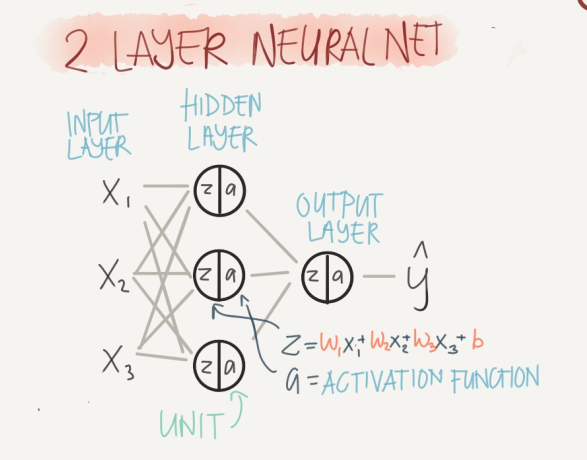

(image taken from https://www.slideshare.net/TessFerrandez/notes-from-coursera-deep-learning-courses-by-andrew-ng)

A neuron consists of inputs, weights on those inputs, a bias, an activation function and outputs.

Make an initial guess of the weights and bias values. For stochastic gradient descent, one training sample is selected at a time and flows forward through the network, with the outputs calculated at one layer flowing into the next layer. When the output layer is reached, the predicted value and the cost is calculated. The data then flows back through the layers of neurons, and the weights and biases are calculated with respect to the cost. The next sample is selected, and this process is repeated until convergence is reached or a set number of iterations have occurred.

### Part 1: Shallow Neural Network

The code below is an implementation of a shallow neural network using Python and NumPy. The code is tested with a non-linearly separable spiral dataset. 

In [47]:
# Package imports
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import pandas as pd
import numpy as np
import random
import math
from copy import deepcopy
from sklearn.model_selection import train_test_split

# Display plots inline and change default figure size
%matplotlib inline

When the data has no natural bounds or there are possible outliers, Z-Normalisation is used to normalise the data.

In [48]:
def z_scale(x, mean, std):
    """
    Z-scale Normalisation function
    :param x: Input value
    :param mean: Mean Value
    :param std: Standard Deviation
    :return: Normalised Values
    """
    return (x - mean) / std

In [49]:
class SigmoidActivation:
    """
    Activation functions help the neural network learn complex patterns.  The
    Sigmoid activation function is used in binary classification problems
    """
    def calculate(self, x):
        """
        During the forward pass we calculate the sigmoid function
        :param x: The input to the neuron
        :return:
        """
        return 1 / (1 + np.exp(-x))

    def calculate_derivative(self, z):
        """
        During the backward pass we calculate the partial derivative of
        the sigmoid function
        :param z: The z value from the previous layer
        :return:
        """
        fz = self.calculate(z)
        g = np.multiply(fz, (1 - fz))
        return g

In [50]:
class Cost:

    @staticmethod
    def compute_cost(y, y_hat):
        """
        y: vector of true value
        y_hat: vector of predicted value
        """
        n = y.shape[0]
        y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
        cost = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return -np.sum(cost) / n

In [51]:
class SGDOptimiser:
    """
    Standard Gradient Descent optimizer
    """

    def update_weights_and_bias(self, alpha, layer, dW, db):
        """
        Update the weights and bias at each step along the gradient descent
        :param alpha: The learning rate
        :param layer: Whether hidden or output layer
        :param dW: Partial derivative of weights
        :param db: artial derivative of bias
        :return:
        """
        weight_increment = np.array((np.multiply(dW, alpha)))
        bias_increment = np.array((np.multiply(db, alpha)))
        layer.weights -= weight_increment
        layer.bias -= bias_increment

In [52]:
class HiddenLayer:

    def __init__(self, number_inputs):
        self.weights = None
        self.bias = None
        self.number_inputs = number_inputs

    # the combination of weights and inputs determines the size of the array
    # which models the connections one layer and the next
    def initialize_weights_and_bias(self, n_neurons):
        """
        Initialize the weights and bias with small random values
        :param n_neurons: Number of neurons in the hidden layer
        :return:
        """
        np.random.seed(0)
        self.weights = 0.01 * np.random.randn(self.number_inputs, n_neurons)
        self.bias = 0.01 * np.random.randn(1, n_neurons)
        #self.bias = np.zeros((1, n_neurons))

    def forward_propagate(self, X, activation_function):
        """
        Forward propagation pass in the hidden layer
        :param X: The inputs to the hidden layer
        :param activation_function: The sigmoid activation function
        :return: The inout and output values for the neurons
        """
        a0 = X
        z1 = np.dot(a0, self.weights) + self.bias
        a1 = activation_function.calculate(z1)
        return z1, a1

    def backward_propagate(self, X, dz2, W, z1, activation_function):
        """
        Backwards propagation pass in the hidden layer
        :param X: Inputs to the hidden layer
        :param dz2: partial derivatives of cost function w.r.t. z from output layer
        :param W: Weights
        :param z1: Z values for hidden layer, could also be class parameter
        :param activation_function: The passed in activation function
        :return: THe partial derivates w.r.t weights and bias
        """
        fpz = activation_function.calculate_derivative(z1)
        sum = np.dot(dz2, W.T)
        dz = np.multiply(fpz, sum)
        dW = np.dot(X.T, dz)
        db = dz
        return dW, db

In [53]:
class OutputLayer:

    def __init__(self):
        self.a2 = None
        self.weights = None
        self.bias = None

    def initialize_weights_and_bias(self, n_neurons):
        """
        Initialize the weights and bias with small random values
        :param n_neurons: Number of neurons in the hidden layer
        :return:
        """
        np.random.seed(0)
        self.weights = 0.01 * np.random.randn(n_neurons, 1)
        self.bias = 0.01 * np.random.randn(1, 1)
        #self.bias = np.zeros((1, 1))

    def forward_propagate(self, inputs, sigmoid):
        """
        Forward propagation pass in the final output layer
        :param inputs: The inputs to the final output layer
        :param sigmoid: The sigmoid activation function
        :return: The predicted value as a probability
        """
        z2 = np.dot(inputs, self.weights) + self.bias
        self.a2 = sigmoid.calculate(z2)
        return self.a2

    def backward_propagate(self, y, a1):
        """
        Backwards propagation pass in the final output layer
        :param y: The true output class values
        :param a1: The output values from the previous, hidden layer
        :return: Th partial derivitaves w.r.t the weights and bias
        """
        dz = self.a2 - y
        dW = np.dot(a1.T, dz)
        db = dz
        return dW, db

In [54]:
class ShallowNN:

    def __init__(self, n_inputs):
        """
        Initialize the neural network
        :param n_inputs: The number of input values
        """
        self.hidden_layer = HiddenLayer(n_inputs)
        self.output_layer = OutputLayer()
        self.sigmoid_activation = SigmoidActivation()
        self.optimizer = SGDOptimiser()
        self.cost = Cost()
        self.loss_metrics = []
        self.val_accuracy_metrics = []
        self.train_accuracy_metrics = []
        self.epochs = 1
        self.alpha = 0
        self.n_neurons = 0

    @staticmethod
    def accuracy(y, y_hat):
        """
        Calculate the accuracy
        :param y: Vector of the true output class values
        :param y_hat: Vector of the predicted output class values
        :return: The percentage accuracy
        """
        if len(y.shape) == 1:
            y = y.reshape((len(y), 1))
        if len(y_hat) == 1:
            y_hat = y_hat.reshape((len(y_hat), 1))
        return np.mean(y == y_hat)

    @staticmethod
    def compute_cost(y, y_hat):
        """
        Calculate the cost using the log loss equation
        Y: Vector of true value
        Y_hat: Vector of predicted value
        """
        y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
        cost = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return cost.item()

    def initialize_gradient_parameters(self, n_neurons):
        """
        Initialize the weights and bias for the hidden and output layers
        To test the hyper-parameters these values can be reinitialized
        on a call to the fit method
        :param n_neurons: The number of neurons in hidden layer
        :return:
        """
        self.hidden_layer.initialize_weights_and_bias(n_neurons)
        self.output_layer.initialize_weights_and_bias(n_neurons)

    def reset_metrics(self):
        """
        Rest the metrics arrays between training runs
        :return:
        """
        self.loss_metrics = []
        self.val_accuracy_metrics = []
        self.train_accuracy_metrics = []

    def calculate_metrics(self, X, X_val, n_epoch, j_curr, y, y_val, j_prev):
        """
        This is a helper function to record the training, validation and cost metrics.
        This enables plotting after training and helps debugging
        :param X: The training dataset
        :param X_val: The validation dataset
        :param n_epoch: The number of epochs to train before stopping
        :param j_curr: The cost for gradient descent
        :param y: Vector of true value of training set
        :param y_val:V ector of true value of validation set
        :param j_prev: previous cost, used in checking for convergence
        :return:
        """
        #print(f'epoch {n_epoch}: loss {j_curr}: loss_delta{abs(j_curr - j_prev)}')
        train_y_hat = self.predict(X)
        train_y_hat = (train_y_hat > 0.5) * 1
        train_accuracy = self.accuracy(y, train_y_hat)
        self.train_accuracy_metrics.append(train_accuracy)
        val_y_hat = self.predict(X_val)
        val_y_hat = (val_y_hat > 0.5) * 1
        val_accuracy = self.accuracy(y_val, val_y_hat)
        #print('accuracy : {}'.format(val_accuracy))
        self.loss_metrics.append(j_curr)
        self.val_accuracy_metrics.append(val_accuracy)

    def fit(self, X, y, X_val, y_val, n_neurons=3, alpha=0.001, n_epochs=200, threshold=1e-7):
        """
        Runs the training algorithm with forward and backward propagation
        :param X: The test training dataset
        :param y: The true test class value
        :param X_val: The validation dataset
        :param y_val: The true validation class value
        :param n_neurons: The number of neurons in the hidden layer
        :param alpha: The learning rate, used in gradient descent step
        :param n_epochs: The number of epochs to train if no convergence
        :param threshold: The convergence threshold
        :return: The training cost
        """
        self.reset_metrics()
        self.initialize_gradient_parameters(n_neurons)
        self.alpha = alpha
        self.n_neurons = n_neurons

        j_curr = 9999

        # 1 epoc is equivalent to all the samples in the data set
        epoch_size = X.shape[0]
        n_iterations = n_epochs * epoch_size

        for i in range(n_iterations):
            j = random.randint(0, len(X) - 1)

            x_row = X[j].reshape(1, -1)
            y_row = y[j].reshape(1)
            # set j_prev for next iteration
            j_prev = j_curr

            # forwards propagation
            z1, a1 = self.hidden_layer.forward_propagate(x_row, self.sigmoid_activation)
            y_hat = self.output_layer.forward_propagate(a1, self.sigmoid_activation)

            # compute the loss
            j_curr = self.compute_cost(y_row, y_hat)

            #backwards propagation
            dWOp, dbOp = self.output_layer.backward_propagate(y_row, a1)
            dWH1, dbH1 = self.hidden_layer.backward_propagate(x_row, dbOp, self.output_layer.weights, z1,
                                                              self.sigmoid_activation)
            self.optimizer.update_weights_and_bias(self.alpha, self.hidden_layer, dWH1, dbH1)
            self.optimizer.update_weights_and_bias(self.alpha, self.output_layer, dWOp, dbOp)

            if i % epoch_size == 0:
                self.calculate_metrics(X, X_val, i/epoch_size, j_curr, y, y_val, j_prev)

            if abs(j_curr - j_prev) < threshold:
                print('Converged on iteration {}, loss {}'.format(i, j_curr))
                return j_curr
            # set j-prev for next iteration
            j_prev = j_curr
        return j_curr

    def predict(self, X):
        z1, a1 = self.hidden_layer.forward_propagate(X, self.sigmoid_activation)
        y_hat = self.output_layer.forward_propagate(a1, self.sigmoid_activation)
        return y_hat

### Training, Testing and Validation

The process used for the training and validation of the shallow neural network is:

Divide the dataset randonly into:

70% Training Set 15% Validation Set 15% Test Set 

- Train the Logistic Regressor model using the Training Set with different learning rates.

- Validate the model using the Validation Set, record the accuracy score and the number of iterations with this validation set and select the model with the best scores.

- Run the model with the test set to get the final accuracy score.

As an aid to training plot the cost of training versus the number of iterations for the best model.

In [55]:
def train_and_select_nn_model(model, X_train, X_val, X_test, y_train, y_val, y_test, dataset_name):
    """
    Train the model with different hyper parameters
    :param model: Neural Network Model to be trained
    :param X_train: Training dataset
    :param X_val: Validation dataset
    :param X_test: Testing dataset
    :param y_train: Training classes
    :param y_val: Validation Classes
    :param y_test: Testing classes
    :param dataset_name: Name of the dataset
    :return: 
    """
    # we want to find the model with the lowest cost
    val_accuracy = 0

    best_model = None
    best_cost = 9999
    rate = None
    acc = None

    learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 0.5]
    for alpha in learning_rates:
        # train the model
        print('train the model, alpha = {}'.format(alpha))
        #train_cost = model.fit(X_train, y_train, alpha)
        train_cost = model.fit(X_train, y_train, X_val, y_val, n_neurons=5, alpha=alpha, n_epochs=360, threshold=1e-7)
        # evauate the model using the validation set
        print('validating the model, alpha = {}'.format(alpha))
        predictions = model.predict(X_val)
        predictions = (predictions > 0.5) * 1
        accuracy = model.accuracy(predictions.reshape((len(y_val), 1)),
                                                  y_val.reshape((len(y_val), 1)))
        if accuracy >= val_accuracy:
            if train_cost < best_cost:
                best_model = model
                rate = alpha
                val_accuracy = accuracy
                best_cost = train_cost

    print("Now test the model using the test set:")
    final_predictions = best_model.predict(X_test)
    final_predictions = (final_predictions > 0.5) * 1
    final_accuracy = model.accuracy(final_predictions.reshape((len(y_test), 1)),
                                                    y_test.reshape((len(y_test), 1)))
    print('Accuracy of model on {} data set is {} with alpha {}'.format(dataset_name, final_accuracy, rate))
    return best_model

Helper function to divide the data in train, validation and test sets.

In [56]:
def prepare_dataset(df):
    """
    Helper function to divide the data in train, validation and test sets.
    :param df: Origional dataset as pandas dataframe
    :return: The dataset divided into train, validation, test
    """
    # shuffle the dataset
    df = df.sample(frac=1).reset_index(drop=True)

    X = df[df.columns[:-1]].values
    X = X.astype('float64')
    y = df[df.columns[-1]].values

    # Split into train, test validation sets with
    # 70% training data, 15% Validation data, 15% Test sata
    # first create the training set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)
    # then split the remaining between test and validation set
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.50,
                                                    random_state=0)

    moons_mean = np.mean(X_train)
    moons_std = np.std(X_train)

    X_train = z_scale(X_train, moons_mean, moons_std)
    X_val = z_scale(X_val, moons_mean, moons_std)
    X_test = z_scale(X_test, moons_mean, moons_std)
    return X_train, X_val, X_test, y_train, y_val, y_test

Helper function to plot the training loss, training accuracy and validation accuracy.

In [57]:
def plot_training_loss_accuracy(model):
    """Helper function to plot the training loss, training accuracy and validation accuracy."""
    epochs = range(0, len(model.loss_metrics))
    # plt.subplot(1, 2, 1)
    plt.plot(epochs, model.loss_metrics, 'g', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # i = len(model.loss_diff_metrics)
    # iterations = np.linspace(1, i, num=i)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, model.train_accuracy_metrics, 'r', label='training accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, model.val_accuracy_metrics, 'b', label='validation accuracy')
    plt.title('Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Usage

Use a non-linearly seperable dataset, prepare the train, validation and test sets and train the model with different learning rate hyper-paramters.

In [58]:
df = pd.read_csv("spiral.csv")
name = 'spiral'

Display the data point

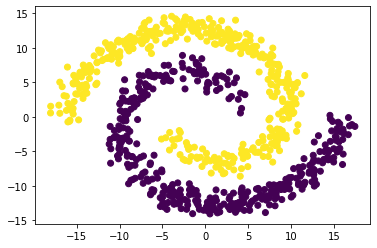

In [59]:
X = df[data.columns[:-1]].values
X = X.astype('float64')
y = df[df.columns[-1]].values
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [60]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(df)

model = ShallowNN(2)
spiral_model = train_and_select_nn_model(model, X_train, X_val, X_test, y_train, y_val, y_test, name)

train the model, alpha = 0.001
Converged on iteration 9229, loss 0.7208793792786707
validating the model, alpha = 0.001
train the model, alpha = 0.003
Converged on iteration 180563, loss 0.11284054352306118
validating the model, alpha = 0.003
train the model, alpha = 0.01
validating the model, alpha = 0.01
train the model, alpha = 0.03
Converged on iteration 174781, loss 0.009612833489058505
validating the model, alpha = 0.03
train the model, alpha = 0.1
Converged on iteration 38863, loss 2.7641092762937954e-05
validating the model, alpha = 0.1
train the model, alpha = 0.3
Converged on iteration 30553, loss 0.0003098152945653695
validating the model, alpha = 0.3
train the model, alpha = 0.5
Converged on iteration 36818, loss 0.0002510590054396034
validating the model, alpha = 0.5
Now test the model using the test set:
Accuracy of model on spiral data set is 0.825 with alpha 0.03


Plot the trainng cost and training and validation accuracy during the training process for the best model. For the accuracy plots, the full validation and training sets are used

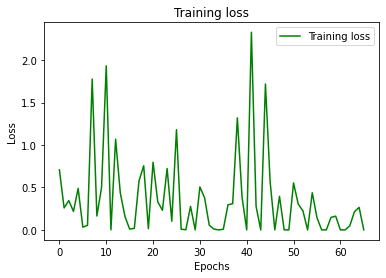

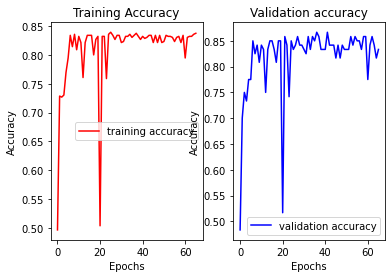

In [61]:
plot_training_loss_accuracy(spiral_model)

### Observations

The neual network was able to predict the values for both the linear and now linear datasets accurately.  Training time took longer with the non-linear moons400 daaset and the cost graph shows a less smooth decay.

# Part 2: Deep Neural Network

### Image recognition
This image recognition task uses the CIFA-10 dataset from:

https://www.cs.toronto.edu/~kriz/cifar.html

The code to load and view the images in the cifar 10 data is based on that provided by Prof. Michael Maden.

All the images were stored in pickle files in the folder cifar-10-batch-py. For the Training and Validation datasets I used the images stored in files data_batch_1, data_batch_2, data_batch_3, data_batch_4 and data_batch_5. For the validation set I used the images stored in test_batch.

In [62]:
# This function taken from the CIFAR website

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


Loaded in this way, each of the batch files contains a dictionary with the following elements:
- data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
- labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The code to load and view the images in the cifar 10 data is based on that provided by Prof. Michael Maden

In [63]:
def load_batch(batchname):
    folder = 'cifar-10-batches-py'
    batch = unpickle(folder + "/" + batchname)
    data = batch[b'data']
    labels_ = batch[b'labels']
    labels_ = np.array(labels_).reshape(-1, 1)
    return data, labels_


In [64]:
def loadlabelnames():
    folder = 'cifar-10-batches-py'
    meta = unpickle(folder + "/" + 'batches.meta')
    return meta[b'label_names']

In [65]:
def covertToGrayScale(data):
    """
    Helper function that slices the image files into RGB sections into three
    seperate arrays and takes the average of these 
    :param data: 
    :return: the image as a greyscale image
    """
    arrR = data[:, 0:1024]
    arrG = data[:, 1024:2048]
    arrB = data[:, 2048:3072]
    gray = np.mean([arrR, arrG, arrB], axis=0)
    return gray

In [66]:
def dogsAndDeerIndex(labels):
    """
    Helper function to identify images containing dogs and deer
    :param labels: The image class labels
    :return: 
    """
    # 4: Deer, 5: Dog
    index = np.where((labels == 4) | (labels == 5))
    return index[0]

Extract the images from the pickle files, extract those images containing dogs and deer and convert those images to grayscale.

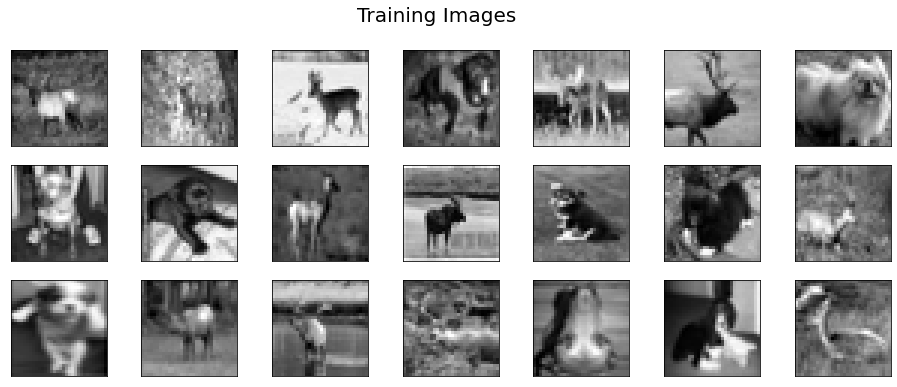

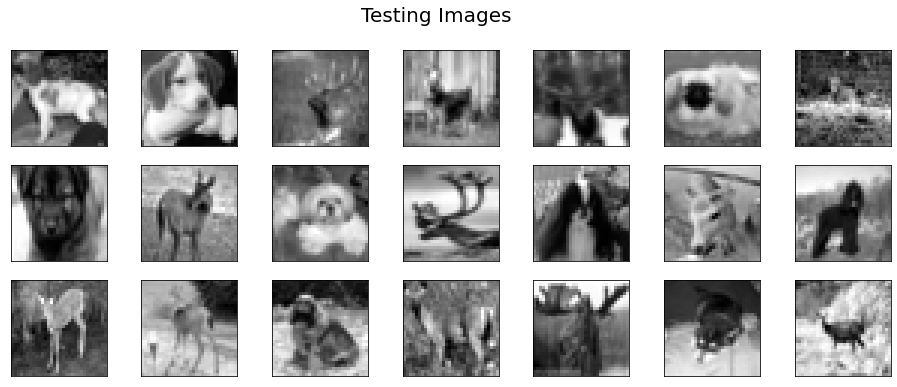

In [67]:
# load the training images
train_data, train_labels = load_batch('data_batch_1')
for i in range(2, 3):
    data, labels = load_batch('data_batch_{}'.format(i))
    train_data = np.vstack((train_data, data))
    train_labels = np.vstack((train_labels, labels))

# identify the dogs and deer indices
indices = dogsAndDeerIndex(train_labels)

#use the indices to extract the dogs and deer images
X_train = train_data[indices]
y_train = train_labels[indices]

# Replace the labels for doegs and deers with 0 and 1
y_train = np.where(y_train == 4, 0, y_train)
y_train = np.where(y_train == 5, 1, y_train)

# convert the images to grayscale
X_train = covertToGrayScale(X_train)

# Repeat this process for the test images 
## test sets
test_data, test_labels = load_batch('test_batch')
test_labels = np.array(test_labels) 

# identify the dogs and deer indices
test_indices = dogsAndDeerIndex(test_labels)
X_test = test_data[test_indices]
y_test = test_labels[test_indices]


# Replace the labels for doegs and deers with 0 and 1
y_test = np.where(y_test == 4, 0, y_test)
y_test = np.where(y_test == 5, 1, y_test)

# convert the images to grayscale
X_test = covertToGrayScale(X_test)


# Display a few images from the training batch
fig = plt.figure(figsize=(16, 6))
fig.suptitle('Training Images', fontsize=20)
for i in range(0, 21):
    ax = fig.add_subplot(3, 7, i + 1, xticks=[], yticks=[])
    plt.imshow(X_train[i].reshape(32, 32), cmap="gray", interpolation="none")
plt.show()

# Display a few images from the test batch
fig = plt.figure(figsize=(16, 6))
fig.suptitle('Testing Images', fontsize=20)
for i in range(0, 21):
    ax = fig.add_subplot(3, 7, i + 1, xticks=[], yticks=[])
    plt.imshow(X_test[i].reshape(32, 32), cmap="gray", interpolation="none")
plt.show()


Scale the datasets

In [68]:
# As the maximium value for greyscale images is 255 we can normalise them by dividing by 255
X_train /= 255
X_test /= 255

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.15, random_state=0)

model = ShallowNN(1024)

In [70]:
def train_and_select_complex_nn_model(model, X_train, X_val, X_test, y_train, y_val, y_test, dataset_name):
    """
    Train the model with different hyper parameters
    :param model: Neural Network Model to be trained
    :param X_train: Training dataset
    :param X_val: Validation dataset
    :param X_test: Testing dataset
    :param y_train: Training classes
    :param y_val: Validation Classes
    :param y_test: Testing classes
    :param dataset_name: Name of the dataset
    :return:
    """
    # we want to find the model with the lowest cost
    val_accuracy = 0

    best_model = None
    best_cost = 9999
    rate = None
    acc = None

    print('Starting training...')
    learning_rates = [0.003, 0.001, 0.03, 0.01]
    number_neurons = [64, 50, 32]
    for a in number_neurons:
        for b in learning_rates:
            # train the model
            train_cost = model.fit(X_train, y_train, X_val, y_val, n_neurons=a, alpha=b, n_epochs=100, threshold=1e-8)

            # evauate the model using the validation set
            predictions = model.predict(X_val)
            predictions = (predictions > 0.5) * 1
            accuracy = model.accuracy(predictions.reshape((len(y_val), 1)),
                                      y_val.reshape((len(y_val), 1)))
            print('With {} neurons and learning rate {}, validation accuracy = {}'.format(a, b, accuracy))
            if accuracy >= val_accuracy:
                if train_cost < best_cost:
                    best_model = deepcopy(model)
                    val_accuracy = deepcopy(accuracy)
    return best_model


Train the model with diffeent hyperparameters, validate with the validation set get the meodel with the highest validatioon score.

In [71]:
q4_model = train_and_select_complex_nn_model(model, X_train, X_val, X_test, y_train, y_val, y_test, 'cifar-dogs-deer')

Starting training...
With 64 neurons and learning rate 0.003, validation accuracy = 0.754653130287648
With 64 neurons and learning rate 0.001, validation accuracy = 0.7428087986463621
With 64 neurons and learning rate 0.03, validation accuracy = 0.7208121827411168
Converged on iteration 298197, loss 1.4578542539384407e-05
With 64 neurons and learning rate 0.01, validation accuracy = 0.688663282571912
With 50 neurons and learning rate 0.003, validation accuracy = 0.751269035532995
With 50 neurons and learning rate 0.001, validation accuracy = 0.7326565143824028
With 50 neurons and learning rate 0.03, validation accuracy = 0.7309644670050761
With 50 neurons and learning rate 0.01, validation accuracy = 0.700507614213198
With 32 neurons and learning rate 0.003, validation accuracy = 0.7461928934010152
With 32 neurons and learning rate 0.001, validation accuracy = 0.7428087986463621
With 32 neurons and learning rate 0.03, validation accuracy = 0.7174280879864636
With 32 neurons and learnin

Now that the model has been trained, use the test set to get an prediction

In [72]:
print('********************************************************************')
print("Now test the model using the test set:")
q4_predictions = q4_model.predict(X_test)
q4_predictions = (q4_predictions > 0.5) * 1
final_accuracy = q4_model.accuracy(q4_predictions.reshape((len(y_test), 1)),
                                y_test.reshape((len(y_test), 1)))
print('Accuracy of model on cifar data set is {} with alpha {}'.format(final_accuracy, q4_model.alpha))
print('********************************************************************')


********************************************************************
Now test the model using the test set:
Accuracy of model on cifar data set is 0.7355 with alpha 0.003
********************************************************************


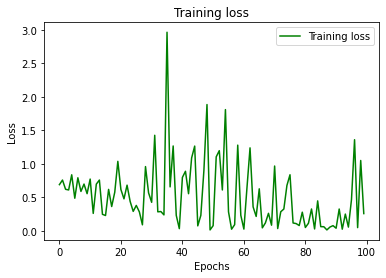

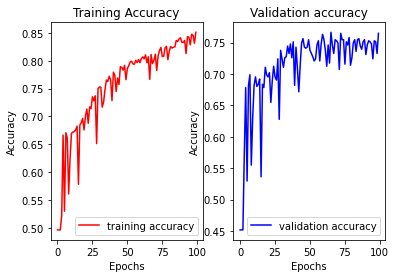

In [73]:
plot_training_loss_accuracy(q4_model)

### Part 5: Deep Learning Enhancements

For the enhancements stage I implemented L2 Regularization, Mini-Batch Stochastic Gradient Descent, Backpropagation with Momentum and the Adam Optimiser 

During training the Adam Optimiser did not perform as well as either standard Stochastic Gradient Descent or when using momentum.  This could be becase of a bug in the implementation but in the neural network below I am using L2 Regularization, Mini-Batch Stochastic Gradient Descent and Backpropagation with Momentum.

Once again the using the cifar-10 images, for the Training and Validation datasets I used the images stored in files data_batch_1, data_batch_2, data_batch_3, data_batch_4 and data_batch_5. For the validation set I used the images stored in test_batch.

L2 Regulatization is a method to avoid overfitting by adding an extra penalty to the cost function, increaing the cost of more cmplex networks. The code for L2 regularization below comes from the algorithm described on slide 27 of DeepLearning-04-DeepNNs-Pt1.pdf.

Mini-Batch gradient descent is a method that seeks to avoid local minima by using small batches of random samples. It also offers efficiency gains in calculations through the use of vectorisation.

Momentum is another method for improving the performance of the neural network by updating parameters at a rate appropiate to themselves, making the contours of the graph decsribed by the parameters of the model more uniform.
The code for both these optimisations comes from the notes DeepLearning-05-DeepNNs-Pt2.pdf.

I have made some changes to the classes used in the neural network so the full code is below:

In [74]:
class SigmoidActivation:
    """
    Activation functions help the neural network learn complex patterns.  The
    Sigmoid activation function is used in binary classification problems
    """
    def calculate(self, x):
        """
        During the forward pass we calculate the sigmoid function
        :param x: The input to the neuron
        :return:
        """
        return 1 / (1 + np.exp(-x))

    def calculate_derivative(self, z):
        """
        During the backward pass we calculate the partial derivative of
        the sigmoid function
        :param z: The z value from the previous layer
        :return:
        """
        fz = self.calculate(z)
        g = np.multiply(fz, (1 - fz))
        return g


In [75]:
class Cost:
    """
    Class to calculate the log loss cost
    """
    @staticmethod
    def compute_cost(y, y_hat):
        """
        Y: vector of true value
        Y_hat: vector of predicted value
        """
        n = y.shape[0]
        y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
        cost = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return -np.sum(cost) / n

    def compute_regularized_cost(self, y, y_hat, lmbda, wh, wo):
        """
        Y: vector of true value
        Y_hat: vector of predicted value
        """
        n = y.shape[0]
        cost = self.compute_cost(y, y_hat)
        # to make it robust for batch gradient descent
        reg = (lmbda / (2 * n)) * (np.sum(np.square(wh)) + np.sum(np.square(wo)))
        reg_cost = cost + reg
        return reg_cost


In [76]:
class SGDOptimiser:
    """
    Standard Gradient Descent optimizer
    """
    def update_weights_and_bias(self, alpha, layer, dW, db):
        """
        Update the weights and bias at each step along the gradient descent
        :param alpha: The learning rate
        :param layer: Whether hidden or output layer
        :param dW: Partial derivative of weights
        :param db: Partial derivative of bias
        :return:
        """
        weight_increment = np.array((np.multiply(dW, alpha)))
        bias_increment = np.array((np.multiply(db, alpha)))
        layer.weights -= weight_increment
        layer.bias -= bias_increment


In [77]:
class Momemtum_Optimiser:
    """
    Allows the parameters to change at a rate appropriate to itself,
    rather than there being one fixed learning rate
    """
    def update_momentum_parms(self, beta, layer, dW, db):
        """
        Update the vectors holding partial derivatives of the Velocity weights and bias
        :param beta: Momemtum parameter
        :param layer: The layer to be updated
        :param dW: Partial derivative of weights
        :param db: Partial derivative of weights
        :return:
        """
        layer.weight_momentum = ((1 - beta) * dW) + (beta * layer.weight_momentum)
        layer.bias_momentum = ((1 - beta) * db) + (beta * layer.bias_momentum)

    def update_weights_and_bias(self, alpha, layer):
        """
        Update weights and bias with momentum derivatives
        :param alpha: The learning rate
        :param layer: The layer to be updated
        :return:
        """
        weight_increment = alpha * layer.weight_momentum
        bias_increment = alpha * layer.bias_momentum
        layer.weights -= weight_increment
        layer.bias -= bias_increment

In [78]:
class AdamOptimiser:
    """
    Combines the ideas from Momentum and RMSprop.  It considers both velocity and
    acceleration terms when calculating the gradient descent
    """
    def update_velocity_acceleration_parms(self, beta1, beta2, layer, dW, db):
        """
        Calculate the partial deriviative values for the acceleration and velocity
        values.
        :param beta1: The velocity moving average parameter
        :param beta2: The acceleration moving average parameter
        :param layer: The layer to be updated
        :param dW: Partial derivative of the Weights
        :param db: Partial deriviative of bias
        :return:
        """
        layer.weight_velocity = ((1 - beta1) * dW) + (beta1 * layer.weight_velocity)
        layer.bias_velocity = ((1 - beta1) * db) + (beta1 * layer.bias_velocity)
        layer.weight_acceleration = ((1 - beta2) * np.square(dW)) + (beta1 * layer.weight_acceleration)
        layer.bias_acceleration = ((1 - beta2) * np.square(db)) + (beta1 * layer.bias_acceleration)
        layer.v_c_dW = layer.weight_velocity / (1 - beta1)
        layer.v_c_db = layer.bias_velocity / (1 - beta1)
        layer.s_c_dW = layer.weight_acceleration / (1 - beta2)
        layer.s_c_db = layer.bias_acceleration / (1 - beta2)


    def update_weights_and_bias(self, alpha, layer):
        """
        Update the weights and bias w.r.t the velocity and acceleration
        :param alpha: The learning rate
        :param layer: The layer to be updated
        :return:
        """
        epsilon = 1e-8
        weight_increment = (alpha * layer.v_c_dW) / (np.sqrt(layer.s_c_dW) + epsilon)
        bias_increment = (alpha * layer.v_c_db) / (np.sqrt(layer.s_c_db) + epsilon)
        layer.weights -= weight_increment
        layer.bias -= bias_increment

In [79]:
class HiddenLayer:
    """
    The Hidden Layer of the Neural Netowrk
    """
    def __init__(self, number_inputs):
        self.number_inputs = number_inputs
        self.weights = None
        self.bias = None
        self.weight_momentum = None
        self.bias_momentum = None

    def initialize_weights_and_bias(self, n_neurons):
        """
        Initialize weights and bias values of a hidden layer.  The
        combination of weights and inputs determines the size of the array
        which models the connections one layer and the next
        :param n_neurons: The number of neurons in the hidden layer
        :return:
        """
        np.random.seed(0)
        self.weights = 0.01 * np.random.randn(self.number_inputs, n_neurons)
        self.bias = 0.01 * np.random.randn(1, n_neurons)

    def initialize_momemtum(self):
        """
        Initialize the momentum weights and bias values
        :return:
        """
        self.weight_momentum = np.zeros_like(self.weights)
        self.bias_momentum = np.zeros_like(self.bias)

    def forward_propagate(self, X, activation_function):
        """
        Forward propagation pass in the hidden layer
        :param X: The inputs to the hidden layer
        :param activation_function: The sigmoid activation function
        :return: The inout and output values for the neurons
        """
        a0 = X
        z1 = np.dot(a0, self.weights) + self.bias
        a1 = activation_function.calculate(z1)
        return z1, a1

    def backward_propagate(self, X, dz2, W, z1, activation_function, lmbda):
        """
        Backwards propagation pass in the hidden layer
        :param X: Inputs to the hidden layer
        :param dz2: partial derivatives of cost function w.r.t. z from output layer
        :param W: Weights
        :param z1: Z values for hidden layer, could also be class parameter
        :param activation_function: The passed in activation function
        :param lmbda: L2 Regularization Value
        :return: THe partial derivates w.r.t weights and bias
        """
        fpz = activation_function.calculate_derivative(z1)
        sum = np.dot(dz2, W.T)
        dz = np.multiply(fpz, sum)
        n = X.shape[0]
        dW = (1/n) * np.dot(X.T, dz) + ((lmbda/n) * self.weights)
        db = (1/n) * np.sum(dz, axis=0, keepdims=True)
        return dW, db

In [80]:
class OutputLayer:

    def __init__(self):
        self.a2 = None
        self.weights = None
        self.bias = None
        self.weight_momentum = None
        self.bias_momentum = None

    def initialize_weights_and_bias(self, n_neurons):
        """
        Initialize the weights and bias with small random values
        :param n_neurons: Number of neurons in the hidden layer
        :return:
        """
        np.random.seed(0)
        self.weights = 0.01 * np.random.randn(n_neurons, 1)
        self.bias = 0.01 * np.random.randn(1, 1)
        #self.bias = np.zeros((1, 1))

    def initialise_momemtum(self):
        """
        Initialize the momentum weights and bias values
        :return:
        """
        self.weight_momentum = np.zeros_like(self.weights)
        self.bias_momentum = np.array([[0.0]])

    def forward_propagate(self, inputs, sigmoid):
        """
        Forward propagation pass in the final output layer
        :param inputs: The inputs to the final output layer
        :param sigmoid: The sigmoid activation function
        :return: The predicted value as a probability
        """
        z2 = np.dot(inputs, self.weights) + self.bias
        self.a2 = sigmoid.calculate(z2)
        return self.a2

    def backward_propagate(self, y, a1, lmbda):
        """
        Backwards propagation pass in the final output layer
        :param y: The true output class values
        :param a1: The output values from the previous, hidden layer
        :param lmbda: L2 Regularization Value
        :return:
        """
        n = y.shape[0]
        dz = self.a2 - y
        dW = (1/n) * np.dot(a1.T, dz) +  ((lmbda/n) * self.weights)
        db = (1/n) * np.sum(dz, axis=0, keepdims=True)
        return dW, db

In [81]:
class NNWithMomReg:

    def __init__(self, n_inputs):
            """
            Initialize the neural network
            :param n_inputs: The number of input values
            """
            self.hidden_layer = HiddenLayer(n_inputs)
            self.output_layer = OutputLayer()
            self.sigmoid_activation = SigmoidActivation()
            self.optimizer = Momemtum_Optimiser()
            self.cost = Cost()
            self.loss_metrics = []
            self.val_accuracy_metrics = []
            self.train_accuracy_metrics = []
            self.epochs = 1
            self.alpha = 0
            self.lmbda = 0
            self.n_neurons = 0

    @staticmethod
    def accuracy(y, y_hat):
        """
        Calculate the accuracy
        :param y: Vector of the true output class values
        :param y_hat: Vector of the predicted output class values
        :return: The percentage accuracy
        """
        return np.mean(y == y_hat)

    def initialize_gradient_parameters(self):
        """
        Initialize the weights and bias for the hidden and output layers
        To test the hyper-parameters these values can be reinitialized
        on a call to the fit method
        :param n_neurons: The number of neurons in hidden layer
        :return:
        """
        self.hidden_layer.initialize_weights_and_bias(self.n_neurons)
        self.hidden_layer.initialize_momemtum()
        self.output_layer.initialize_weights_and_bias(self.n_neurons)
        self.output_layer.initialise_momemtum()

    def update_gradient_parameters(self, alpha, beta, dWH1, dWOp, dbH1, dbOp):
        """
        Update the weights and bias for the hidden and output layers
        :param alpha: The learning Rate
        :param beta1: The velocity rate
        :param beta2: The acceleration parameter
        :param dWH1: Partial derivative of hidden layer weight
        :param dWOp: Partial derivative of output layer weight
        :param dbH1: Partial derivative of hidden layer bias
        :param dbOp: Partial derivative of output layer bias
        :return:
        """
        # update weights and bias
        # update weights and bias
        self.optimizer.update_momentum_parms(beta, self.hidden_layer, dWH1, dbH1)
        self.optimizer.update_momentum_parms(beta, self.output_layer, dWOp, dbOp)
        self.optimizer.update_weights_and_bias(alpha, self.hidden_layer)
        self.optimizer.update_weights_and_bias(alpha, self.output_layer)

    def reset_metrics(self):
        """
        Rest the metrics arrays between training runs
        :return:
        """
        self.loss_metrics = []
        self.val_accuracy_metrics = []
        self.train_accuracy_metrics = []

    def calculate_metrics(self, X, X_val, j_curr, y, y_val, n_epoch, j_prev):
        """
        This is a helper function to record the training, validation and cost metrics.
        This enables plotting after training and helps debugging
        :param X: The training dataset
        :param X_val: The validation dataset
        :param n_epoch: The number of epochs to train before stopping
        :param j_curr: The cost for gradient descent
        :param y: Vector of true value of training set
        :param y_val:V ector of true value of validation set
        :param j_prev: previous cost, used in checking for convergence
        :return:
        """
        train_y_hat = self.predict(X)
        train_y_hat = (train_y_hat > 0.5) * 1
        train_accuracy = self.accuracy(y, train_y_hat)
        self.train_accuracy_metrics.append(train_accuracy)
        val_y_hat = self.predict(X_val)
        val_y_hat = (val_y_hat > 0.5) * 1
        val_accuracy = self.accuracy(y_val, val_y_hat)
        #print(f'epoch {n_epoch}: loss {j_curr}: train_accuracy: {train_accuracy} val_accuracy : {val_accuracy}')
        self.loss_metrics.append(j_curr)
        self.val_accuracy_metrics.append(val_accuracy)

    def fit(self, X, y, X_val, y_val, n_neurons=50, alpha=0.001, lmbda=0.0, batch_size=8,
            n_epochs=200, beta=0.9, threshold=1e-7):
        """
        Runs the training algorithm with forward and backward propagation
        :param X: The test training dataset
        :param y: The true test class value
        :param X_val: The validation dataset
        :param y_val: The true validation class value
        :param n_neurons: The number of neurons in the hidden layer
        :param alpha: The learning rate, used in gradient descent step
        :param lmbda: L2 Regularization Value
        :param batch_size: Batch size for mini batch gradient descent
        :param n_epochs: The number of epochs to train if no convergence
        :param beta: The momentum moving average parameter
        :param threshold: The convergence threshold
        :return:
        """
        self.reset_metrics()
        self.alpha = alpha
        self.lmbda = lmbda
        self.n_neurons = n_neurons
        self.initialize_gradient_parameters()

        j_prev = 9999
        j_curr = 9999

        # 1 epoc is equivalent to all the samples in the data set
        epoch_size = X.shape[0]
        n_iterations = n_epochs * epoch_size

        # how may mini batches?
        m = epoch_size/batch_size

        for k in range(n_epochs):

            # Shuffle the array
            training_data = np.hstack((X, y))
            np.random.shuffle(training_data)

            for j in range(0, epoch_size, batch_size):
                #j = k
                batch_data = training_data[j:j+batch_size]
                X_batch, y_batch = batch_data[:, :-1], batch_data[:, -1].reshape(-1, 1)
                j_prev = j_curr

                # forward propagation
                z1, a1 = self.hidden_layer.forward_propagate(X_batch, self.sigmoid_activation)
                y_hat = self.output_layer.forward_propagate(a1, self.sigmoid_activation)
                # compute cost
                j_curr = self.cost.compute_regularized_cost(y_batch, y_hat, self.lmbda,
                                                            self.hidden_layer.weights, self.output_layer.weights)

                if abs(j_curr - j_prev) < threshold and k > 0:
                    print('Converged on iteration {}, loss {}'.format(k, j_curr))
                    return j_curr
                    # set j-prev for next iteration

                # backwards propagation
                dWOp, dbOp = self.output_layer.backward_propagate(y_batch, a1, self.lmbda)
                dWH1, dbH1 = self.hidden_layer.backward_propagate(X_batch, dbOp, self.output_layer.weights, z1,
                                                                  self.sigmoid_activation, self.lmbda)
                self.update_gradient_parameters(self.alpha, beta, dWH1, dWOp, dbH1, dbOp)
            self.calculate_metrics(X, X_val, j_curr, y, y_val, k, j_prev)
        return j_curr

    def predict(self, X):
        z1, a1 = self.hidden_layer.forward_propagate(X, self.sigmoid_activation)
        y_hat = self.output_layer.forward_propagate(a1, self.sigmoid_activation)
        return y_hat

In [82]:
def train_and_select_momentum_nn_model(model, X_train, X_val, y_train, y_val, epochs, batch_size):
    """
    Train the model with different hyper parameters
    :param model: Neural Network Model to be trained
    :param X_train: Training dataset
    :param X_val: Validation dataset
    :param X_test: Testing dataset
    :param y_train: Training classes
    :param y_val: Validation Classes
    :param y_test: Testing classes
    :param epochs: The number of epocs to run for
    :return:
    """
    # we want to find the model with the highest validation accuracy and lowest cost
    best_model = None
    best_cost = 9999
    best_lr_rate = None
    best_val_acc = 0
    best_neurons = 1024
    best_momentum = None

    number_neurons = [64, 50]
    learning_rates = [0.003, 0.001, 0.03, 0.01]
    momentum_rates = [0.00001, 0.0001]

    print('Starting training...')
    for a in number_neurons:
        for b in learning_rates:
            for c in momentum_rates:
                # train the model

                train_cost = model.fit(X_train, y_train, X_val, y_val, n_neurons=a, alpha=b,
                                       lmbda=c, beta=0.9, batch_size=batch_size ,n_epochs=epochs, threshold=1e-8)

                # evauate the model using the validation set
                #print('validating the model, n_neurons = {}, alpha = {},'.format(a, b))
                predictions = model.predict(X_val)
                predictions = (predictions > 0.5) * 1
                accuracy = model.accuracy(predictions.reshape((len(y_val), 1)),
                                          y_val.reshape((len(y_val), 1)))
                print('trained the model with: n_neurons = {}, alpha = {}, momentum = {} validation accuracy = {}'.format(a, b, c, accuracy,))
                if accuracy >= best_val_acc:
                    best_model = deepcopy(model)
                    best_val_acc = deepcopy(accuracy)

    print('Finished Training')
    return best_model

In [83]:
q5_model = NNWithMomReg(1024)

Run the neual netowrk with different hyperparameters and a batch size of 1 to cmpare with previous implementation

In [84]:
q5_model = train_and_select_momentum_nn_model(q5_model, X_train, X_val, y_train, y_val, 100, 1)

Starting training...
trained the model with: n_neurons = 64, alpha = 0.003, momentum = 1e-05 validation accuracy = 0.754653130287648
trained the model with: n_neurons = 64, alpha = 0.003, momentum = 0.0001 validation accuracy = 0.754653130287648
trained the model with: n_neurons = 64, alpha = 0.001, momentum = 1e-05 validation accuracy = 0.7326565143824028
trained the model with: n_neurons = 64, alpha = 0.001, momentum = 0.0001 validation accuracy = 0.7309644670050761
trained the model with: n_neurons = 64, alpha = 0.03, momentum = 1e-05 validation accuracy = 0.7140439932318104
trained the model with: n_neurons = 64, alpha = 0.03, momentum = 0.0001 validation accuracy = 0.7072758037225042
trained the model with: n_neurons = 64, alpha = 0.01, momentum = 1e-05 validation accuracy = 0.7461928934010152
trained the model with: n_neurons = 64, alpha = 0.01, momentum = 0.0001 validation accuracy = 0.739424703891709
trained the model with: n_neurons = 50, alpha = 0.003, momentum = 1e-05 valida

In [85]:
print('')                    
print('********************************************************************')
print("After training, test the model using the test set:")
final_predictions = q5_model.predict(X_test)
final_predictions = (final_predictions > 0.5) * 1
final_accuracy = q5_model.accuracy(final_predictions.reshape((len(y_test), 1)),
                                y_test.reshape((len(y_test), 1)))
print('Accuracy of model on cifar-10 dataset for dogs and deer is {} with {} neurons, learning rate: {} and momentum: {}'.
      format(final_accuracy, q5_model.n_neurons, q5_model.alpha, q5_model.lmbda))
print('********************************************************************')


********************************************************************
After training, test the model using the test set:
Accuracy of model on cifar-10 dataset for dogs and deer is 0.7265 with 50 neurons, learning rate: 0.01 and momentum: 1e-05
********************************************************************


The validation score was the same for two model, so test with the other highest score for completness

In [86]:
new_model = NNWithMomReg(1024)


train_cost = new_model.fit(X_train, y_train, X_val, y_val, n_neurons=64, alpha=0.01,
                                       lmbda=0.0001, beta=0.9, batch_size=1 ,n_epochs=100, threshold=1e-9)

In [87]:
print('')                    
print('********************************************************************')
print("After training, test the model using the test set:")
final_predictions = new_model.predict(X_test)
final_predictions = (final_predictions > 0.5) * 1
final_accuracy = new_model.accuracy(final_predictions.reshape((len(y_test), 1)),
                                y_test.reshape((len(y_test), 1)))
print('Accuracy of model on cifar-10 dataset for dogs and deer is {} with {} neurons, learning rate: {} and momentum: {}'.
      format(final_accuracy, new_model.n_neurons, new_model.alpha, new_model.lmbda))
print('********************************************************************')


********************************************************************
After training, test the model using the test set:
Accuracy of model on cifar-10 dataset for dogs and deer is 0.7435 with 64 neurons, learning rate: 0.01 and momentum: 0.0001
********************************************************************


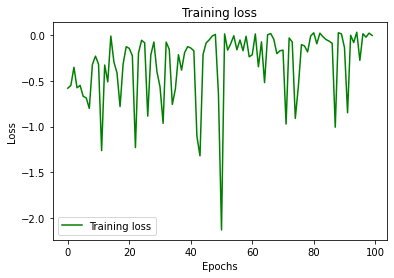

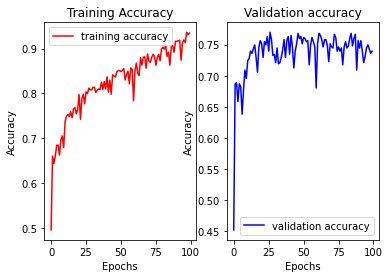

In [88]:
plot_training_loss_accuracy(new_model)

Now lets increase the batch size to 20 to compare mini-batch gradient descent vs stochastic gradient descent

In [89]:
print('')                    
print('********************************************************************')
print("After training, test the model using the test set:")
final_predictions = q5_model.predict(X_test)
final_predictions = (final_predictions > 0.5) * 1
final_accuracy = q5_model.accuracy(final_predictions.reshape((len(y_test), 1)),
                                y_test.reshape((len(y_test), 1)))
print('Accuracy of model on cifar-10 dataset for dogs and deer is {} with {} neurons, learning rate: {} and momentum: {}'.
      format(final_accuracy, q5_model.n_neurons, q5_model.alpha, q5_model.lmbda))
print('********************************************************************')


********************************************************************
After training, test the model using the test set:
Accuracy of model on cifar-10 dataset for dogs and deer is 0.7265 with 50 neurons, learning rate: 0.01 and momentum: 1e-05
********************************************************************


The mini batch metod was much faster to train but in this instance was less accurate.